In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Conv2D, MaxPool2D, Flatten, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, binary_crossentropy, mean_squared_error
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from sklearn.model_selection import KFold
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import load_model

In [3]:
def plot_img(data):
    # show figures in the dataset
    fig = plt.figure(figsize = (24,3))
    plt.imshow(data.reshape(28,28) , cmap = plt.get_cmap('gray'))
    plt.show()

In [4]:
def printest(args, valor):
    return print( "{} : \n {} \n".format(args, valor) )

# Variational Autoencoder: Layer Classes

## Encoder

In [78]:
class Encoder(Layer):
    def __init__(self, layer_sizes: list[int] = [512, 256, 128], 
                        input_size: tuple = (28,28,1),
                        activation: str = 'relu', 
                        initializer: str = "he_uniform",
                        name = "Encoder") -> None:
        """
        Encoder Layer.

        Parameters:
        layer_sizes (List[int]): A list containing the number of units to be used in each Dense layer.
        activation (str): The activation function to be used in the Dense layers.
        initializer (str): The initializer to be used in the Dense layers.
        """

        super(Encoder, self).__init__(name = name)
        self.layer_size = layer_sizes
        self.input_size = input_size
        self.activation = activation
        self.initializer = initializer

        # Flatten Layer
        self.flatten = Flatten(name='Flatten')

        # Hidden Layers
        self.layers = []
        count = 0
        for size in layer_sizes:
            self.layers.append(Dense(units=size,
                                     kernel_initializer=self.initializer,
                                     activation=self.activation,
                                     name='DenseEncoder_{}'.format(count)))
            count += 1

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Performs the forward pass of the encoder layer.

        Parameters:
        x (tf.Tensor): The input tensor to be encoded.

        Returns:
        tf.Tensor: The encoded tensor.
        """

        x = self.flatten(x)
        for layer in self.layers:
            x = layer(x)
        return x

## Latent

The latent space is responsible for transforming the features extracted by the encoder into a lower-dimensional representation that can be used by the decoder to reconstruct the input data. The latent space can be thought of as a continuous space that encapsulates the relationships between the input data points.

In [79]:
class Latent(Layer):
    def __init__(self, 
                 encoder: Encoder,  
                 dense_units: int = 32,  
                 dense_activation: str = 'relu',
                 mean_var_units: int = 2,  
                 mean_var_activation: str = None, 
                 initializer: str = 'he_uniform',
                 name: str = 'Latent'  
                ) -> None:

        """
        Latent Layer.
        
        Parameters:
        encoder (Encoder): An instance of the Encoder class.
        layer_sizes (int): The number of units (neurons) to be used in the Dense layer.
        activation (str): The activation function to be used in the Dense layers.
        initializer (str): The initializer to be used in the Dense layers.
        """

                       
        super(Latent, self).__init__(name = name)
        self.encoder = encoder  
        self.dense_units = dense_units
        self.dense_activation = dense_activation  
        self.mean_var_units = mean_var_units  
        self.mean_var_activation = mean_var_activation
        self.initializer = initializer  
        
        # Invert list of encoder layers to pass as the decoder layers
        # Decoder class will have access to decoder_layers
        self.decoder_layer_sizes = encoder.layer_size[::-1]

        self.dense_layer = Dense( units = dense_units, 
                        kernel_initializer = self.initializer, 
                        activation = self.dense_activation,
                        name = 'DenseLatent' )

        # Dense layer for mean
        self.mean_layer = Dense(units=self.mean_var_units, 
                                activation = self.mean_var_activation,
                                kernel_initializer=self.initializer,
                                name='Mean')
        
        # Dense layer for log-variance
        self.log_var_layer = Dense(units=self.mean_var_units, 
                                  activation = self.mean_var_activation,
                                  kernel_initializer=self.initializer,
                                  name='LogVar')

    def call(self, x: tf.Tensor) -> tf.Tensor:

        """
        Forward pass of the Latent layer.

        Args:
        x (tf.Tensor): The input tensor.

        Returns:
        x (tf.Tensor): A list containing the mean and log-variance tensors.
        """
        x = self.dense_layer(x)
        # Compute the mean and variance
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        return  [mean, log_var]

## Sampling

**Reparameterization trick**

The reparameterization trick is crucial for training the VAE because it enables backpropagation through the sampling process, which would otherwise be non-differentiable. By introducing a random noise vector $\epsilon$ and transforming it using the mean $\mu$ and standard deviation $\sigma$, we can optimize the VAE's parameters during training by computing gradients through the differentiable transformation.

This trick involves introduces a new variable $\epsilon$ which is sampled from a standard normal distribution $N(0,I)$, where $I$ is the identity matrix. Then, we obtain a sample $z$ from the desired distribution by transforming $\epsilon$ using the mean $\mu$ and standard deviation $\sigma$ obtained from the encoder output:

$$z = \mu + \sigma \odot \epsilon$$

Here, $\sigma$ is the standard deviation, obtained as  $\sigma^2 = \exp(\log(\sigma^2))$ or $\sigma= \exp{(\frac{log(\sigma^2)}{2})}$, and $\epsilon$ is a random noise vector sampled from a standard normal distribution. This transformation is differentiable, so we can backpropagate through it to train the network. 

In [80]:
class Sampling(Layer):
    def __init__(self, latent: Latent, name: str = 'Sampling'):
        """
        Initialize the Sampling layer.

        Args:
            latent (Latent): Latent layer instance, used to obtain mean and log variance values.
        """
        super(Sampling, self).__init__(name = name)

        self.latent = latent

        # Create a Lambda layer that applies the sampling function
        self.z_layer = Lambda(self.sampling, name="ZLayer")

    def sampling(self, args):
        """
        Sampling function to generate z using the reparameterization trick.

        Args:
            args (list): List containing z_mean and z_log_var tensors.

        Returns:
            z (tensor): Sampled latent vector.
        """
        z_mean, z_log_var = args
        # Sample epsilon from a standard normal distribution with the same shape as mean
        epsilon = tf.random.normal(
            shape=tf.shape(z_mean), mean=0.0, stddev=1.0)
        # Compute z using the reparameterization trick
        z = z_mean + tf.math.exp(z_log_var / 2) * epsilon
        return z

    def call(self, inputs):
        """
        Forward pass of the Sampling layer.

        Args:
            inputs (list): List containing z_mean and z_log_var tensors.

        Returns:
            z (tensor): Sampled latent vector.
        """
        z_mean, z_log_var = inputs
        
        # Apply the Lambda layer with the sampling function to obtain z
        z = self.z_layer([z_mean, z_log_var])

        return z


## Decoder

In [81]:
class Decoder(Layer):
    def __init__(self, sampling: Sampling, 
                 activation: str = 'relu', 
                 output_activation: str = 'sigmoid',  
                 initializer: str = "he_uniform", 
                 name: str = "Decoder" ) -> None:
        """Decoder Layer.

        Parameters:
        - latent: Latent object used to access the decoder layer sizes.
        
        - activation: Activation function for the dense layers.

        - output_activation: Activation function for the output layers.

        - initializer: Weights initializer for the dense layers.

        - input_img_size: Is the size of each image in the dataset. 
           Used to calculate the number of units in the output layer. 
        """
        super(Decoder, self).__init__(name = name)
        
        self.sampling = sampling
        self.activation = activation
        self.output_activation = output_activation
        self.initializer = initializer
        self.vae_input_size = self.sampling.latent.encoder.input_size

        # Output size defined accordingly to the Encoder input layer size
        # the idea is generate a symmetric number of layers compared to the Encoder
        self.layer_sizes = sampling.latent.decoder_layer_sizes

        # Hidden Layer
        self.layers = []
        count = 0
        for size in self.layer_sizes:
            self.layers.append(Dense(units=size, 
                                     kernel_initializer=self.initializer, 
                                     activation=self.activation,
                                     name='DenseDecoder_{}'.format(count)))
            count += 1
        
        self.layers.append(Dense(units= np.prod(self.vae_input_size), 
                                 kernel_initializer=self.initializer, 
                                 activation=self.output_activation, 
                                 name='Output'))
        
        self.reshape = Reshape(target_shape=self.vae_input_size)
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Perform the forward step of the decoder layer.

        Parameters:
        x (Tensor): The input tensor.
        
        Returns:
        Tensor: output tensor.
        
        """
        for layer in self.layers:
            x = layer(x)
        x = self.reshape(x)
        return x


# Variational Autoencoder: Model

The VAE model is trained by minimizing a loss function that consists of two parts:

- Reconstruction loss: 

This measures the difference between the input data $x$ and the reconstructed data $\hat{x}$. It encourages the decoder to produce accurate reconstructions of the input data. The binary cross-entropy loss is used to measure this difference:

$$L_{reconstruction} = -\sum_{i=1}^{n} x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i)$$

Even though the input and output are not binary classification labels. The reason is that the binary cross-entropy loss measures the difference between two probability distributions, and in this case, we can treat the input and reconstructed data as probability distributions.

The term $x_i \log(\hat{x}_i)$ corresponds to the contribution of the "positive" aspect of a feature, meaning that the feature is present in the input data ($x_i = 1$). The term $(1 - x_i) \log(1 - \hat{x}_i)$ corresponds to the contribution of the "negative" aspect of a feature, meaning that the feature is absent in the input data ($x_i = 0$).The negative sign is used because the logarithm of values between 0 and 1 is negative, and we want to minimize the loss.


  - Kullback-Leibler (KL) divergence: 
   
This measures the difference between the learned latent distribution (with parameters µ and σ) and a standard normal distribution. It acts as a regularization term, encouraging the latent space to have a meaningful and structured representation.
$$L_{KL} = -\frac{1}{2} \sum_{j=1}^{k} (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)$$

The total loss for the VAE is the sum of the reconstruction loss and the KL divergence:

$$L_{VAE} = \alpha L_{reconstruction} + \beta L_{KL}$$

In [90]:
class VAE(Model):
    def __init__(self, 
                 encoder: Encoder,
                 latent: Latent,
                 sampling: Sampling,
                 decoder: Decoder,
                 alpha: int = 1,
                 beta: int = 1 ):
        """
        Variational Autoencoder (VAE) class that combines Encoder, Latent, Sampling, and Decoder components.

        Parameters:
        encoder (Encoder): Encoder layer instance.
        latent (Latent): Latent layer instance.
        sampling (Sampling): Sampling layer instance.
        decoder (Decoder): Decoder layer instance.
        alpha (int): Weight for the reconstruction loss.
        beta (int): Weight for the KL-divergence loss.
        """
        super(VAE, self).__init__()

        # Assign the provided components
        self.encoder = encoder
        self.latent = latent
        self.sampling = sampling
        self.decoder = decoder

        # Set the alpha and beta weights for the losses
        self.beta = beta
        self.alpha = alpha
        
        # Initialize loss trackers
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean( name="reconstruction_loss" )
        self.kl_loss_tracker = Mean(name="kl_loss")

    def call(self, x):
        # Pass the input through the Encoder
        x = self.encoder(x)
        # Compute the mean and log-variance of the latent distribution
        z_mean, z_log_var = self.latent(x)
        # Sample a latent point from the distribution
        z = self.sampling([z_mean, z_log_var])
        x  = self.decoder(z)
        
        return x, z, z_mean, z_log_var 
    
    def build_model(self): 
        x = Input((28,28,1), name = "Input")
        return Model( inputs = x, 
                      outputs = self.call(x) )
    
    # Define metrics property to return the loss trackers
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    # Train step function
    def train_step(self, data):
        return self._process_step(data, training = True)
    
    # Test step function
    def test_step(self, data):
        return self._process_step(data, training = False)
    
    # Shared function for both train and test steps
    def _process_step(self, data, training):
        # Unpack the data tuple
        x, y = data

        # Record operations for automatic differentiation
        with tf.GradientTape(persistent = True) as tape:
            # Forward pass through the VAE
            y_pred,_ , z_mean, z_log_var = self(x, training = training )
            # Compute the total loss
            total_loss  = self.compute_loss(y , y_pred, z_mean, z_log_var)

        # Compute and apply gradients if in training mode
        if training:
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(self.reconstruction_loss)
        self.kl_loss_tracker.update_state(self.kl_loss)
        
        # Return the losses as a dictionary
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def compute_loss(self, x, y_pred, z_mean, z_log_var):
        """
        Compute the total loss as a combination of reconstruction and KL-divergence losses.

        Args:
        x: Input data.
        y_pred: Predictions returned by the model (output of `model(x)`).
        z_mean: Mean of the latent distribution.
        z_log_var: Log-variance of the latent distribution.

        Returns:
        The total loss as a `tf.Tensor`.
        """
        # Compute the reconstruction loss (pixel-wise mean squared error)
        self.reconstruction_loss = self.alpha * tf.reduce_mean(binary_crossentropy(x , y_pred))

        # Compute the KL-divergence loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.kl_loss = self.beta * tf.reduce_mean(kl_loss, axis=1)
        
        # Calculate the total loss as the sum of the reconstruction and KL-divergence losses
        total_loss = self.reconstruction_loss + self.kl_loss

        return total_loss


## Model Summary

In [64]:
input = Input((28,28,1))
encoder = Encoder()
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae = Model(inputs = input, outputs = decoder.call(sampling.call( latent.call(encoder.call(input)))))

vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Flatten (Flatten)              (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 DenseEncoder_0 (Dense)         (None, 512)          401920      ['Flatten[0][0]']                
                                                                                                  
 DenseEncoder_1 (Dense)         (None, 256)          131328      ['DenseEncoder_0[0][0]']         
                                                                                            

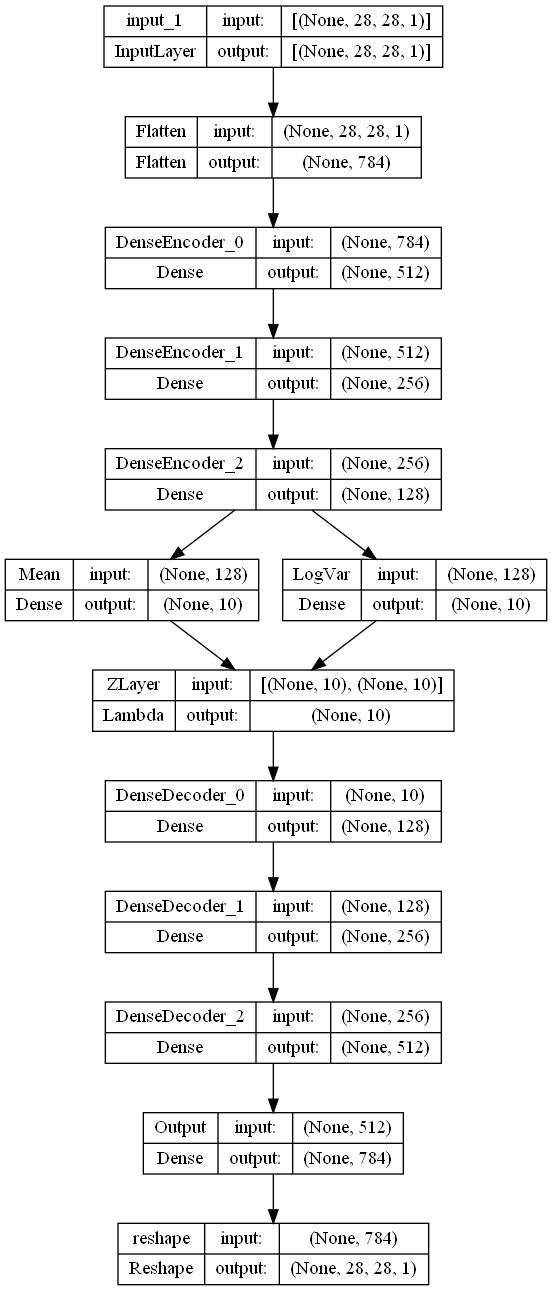

In [10]:
plot_model(vae, show_shapes=True, show_layer_names=True)

In [65]:
encoder = Encoder()
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae =  VAE(encoder, latent, sampling, decoder).build_model()
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Encoder (Encoder)              (None, 128)          566144      ['Input[0][0]']                  
                                                                                                  
 Latent (Latent)                [(None, 2),          570404      ['Encoder[0][0]']                
                                 (None, 2)]                                                       
                                                                                                  
 Sampling (Sampling)            (None, 2)            570404      ['Latent[0][0]',           

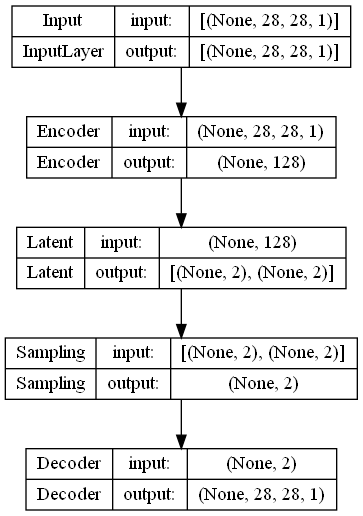

In [66]:
plot_model(vae, show_shapes=True, show_layer_names=True)

# Main

In [83]:
train = pd.read_csv('Data/mnist_train_small.csv')
test = pd.read_csv('Data/mnist_test_small.csv')

x_train = train.drop('label', axis = 1).to_numpy()
x_train = x_train.astype('float32') / 255.0

x_test = test.drop('label', axis = 1).to_numpy()
x_test = x_test.astype('float32') / 255.0

# reshape dataset to have a single channel
# Reshape (20000,784) ->  (2000,     28,     28,     1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)
y_data = train['label'].to_numpy()

In [91]:
encoder = Encoder()
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae =  VAE(encoder, latent, sampling, decoder, alpha = 1000, beta = 1)

vae.compile(optimizer = Adam(learning_rate = 0.0005))
history = vae.fit(x_train, x_train, epochs = 50, batch_size=32, validation_data=(x_test, x_test) )

Epoch 1/50
625/625 [==============================] - 7s 10ms/step - loss: 292.5388 - reconstruction_loss: 241.1221 - kl_loss: 2.9605 - val_loss: 218.0673 - val_reconstruction_loss: 214.7503 - val_kl_loss: 3.3187
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 214.2253 - reconstruction_loss: 207.0836 - kl_loss: 3.3247 - val_loss: 202.1272 - val_reconstruction_loss: 198.5381 - val_kl_loss: 3.5845
Epoch 3/50
625/625 [==============================] - 6s 10ms/step - loss: 200.9413 - reconstruction_loss: 195.4721 - kl_loss: 3.5038 - val_loss: 195.7702 - val_reconstruction_loss: 191.9059 - val_kl_loss: 3.8590
Epoch 4/50
625/625 [==============================] - 6s 10ms/step - loss: 193.9370 - reconstruction_loss: 189.4419 - kl_loss: 3.5946 - val_loss: 191.4321 - val_reconstruction_loss: 187.9292 - val_kl_loss: 3.5018
Epoch 5/50
625/625 [==============================] - 6s 10ms/step - loss: 190.4822 - reconstruction_loss: 185.9594 - kl_loss: 3.6344 - val_loss: 18

# Show results

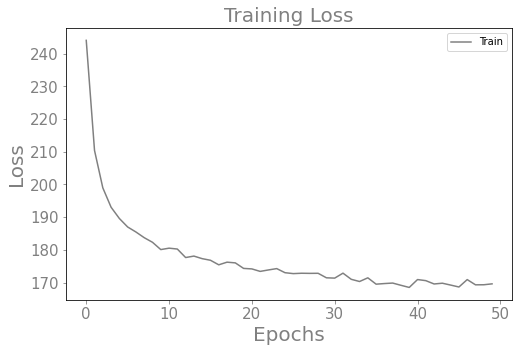

In [92]:
fig, axs = plt.subplots(figsize=(8,5))

axs.plot(history.history['loss'], color = 'gray')
axs.set_title('Training Loss', color = 'gray',fontsize =20)
axs.set_xlabel('Epochs', color = "gray", fontsize =20)
axs.set_ylabel('Loss', color = "gray", fontsize =20)
axs.tick_params(axis ='both', colors = 'gray', labelsize = 15)
axs.legend(['Train'])

plt.show()

625/625 [==============================] - 2s 3ms/step


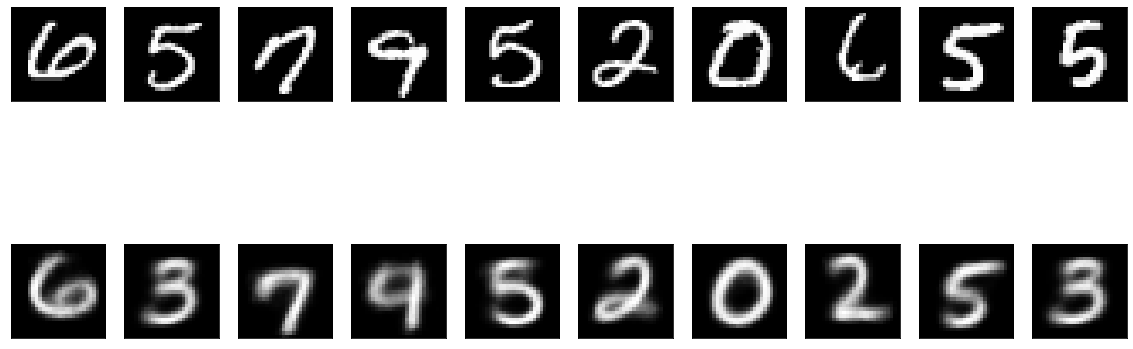

In [93]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Reconstructed images
    vae.predict(x_train)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(vae.predict(x_train)[0][i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [97]:
def plot_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(20, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=1,
                s=50)
    plt.colorbar()
    plt.show()

625/625 [==============================] - 2s 3ms/step


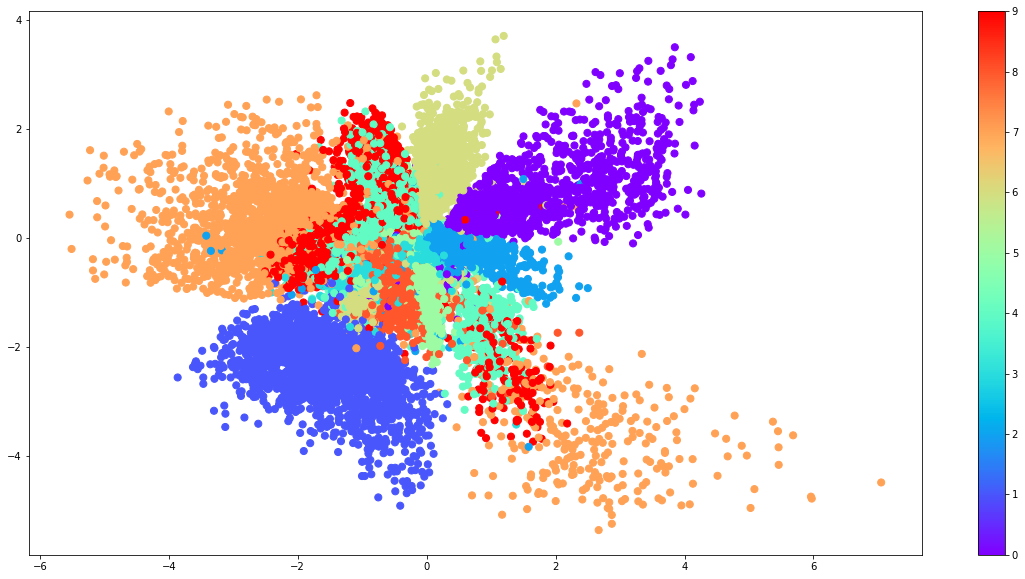

In [98]:
z_mean = vae.predict(x_train)[1]
plot_latent_space(z_mean, y_data)